In [1]:
import datetime as dt
from statistics import mean
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm
import portion as P
length_packet = 400

def rtt_plot(df):
    l1 = []
    l2 = []
    for i in tqdm(range(len(df))):
        if not np.isnan(df.loc[i, "tcp.analysis.ack_rtt"]):
            l1.append(df.loc[i, "frame.time"])
            l2.append(df.loc[i, "tcp.analysis.ack_rtt"])
    print("mean:", np.mean(l2))
    plt.plot(l1, l2)
    plt.show()



def get_seq_time(rx_pcap):
    rxdf = pd.read_csv(rx_pcap, sep='@')
    rxdf.loc[:, "frame.time"] = pd.to_datetime(rxdf.loc[:, r"frame.time"]).dt.tz_localize(None)
    # map seq to time
    
    rseq_time_list  = []
    tseq_time_list  = []

    for i in tqdm(range(len(rxdf))):
        if rxdf.loc[i, "tcp.len"] >= length_packet and rxdf.loc[i, "ip.src"] == "140.112.20.183":
            bias = rxdf.loc[i, "tcp.payload"].find("0000000062")
            dup_num = (rxdf.loc[i, "tcp.len"] -bias) // length_packet
            packet_time = rxdf.loc[i, "frame.time"]
            for j in range(dup_num):
                seq = int(rxdf.loc[i, "tcp.payload"][bias+32+j*length_packet*2:bias+48+j*length_packet*2], 16)
#                 print(seq)
                rseq_time_list.append((seq, packet_time))

def get_client_ul_seq(txdf):
    length_packet = 400
    tseq_time_dict = {}
    ip_set = set(txdf.loc[:, "ip.src"])
    ip_set.remove("140.112.20.183")
    for i in tqdm(range(len(txdf))):
        if txdf.loc[i, "tcp.len"] >= length_packet and txdf.loc[i, "ip.dst"] == "140.112.20.183":
            bias = txdf.loc[i, "tcp.payload"].find("0000018")
            if bias == -1:
                continue
            dup_num = (txdf.loc[i, "tcp.len"] -bias) // length_packet
            packet_time = txdf.loc[i, "frame.time"]
            for j in range(dup_num):
                seq = int(txdf.loc[i, "tcp.payload"][bias+16+j*length_packet*2:bias+24+j*length_packet*2], 16)
                born_time = int(txdf.loc[i, "tcp.payload"][bias+j*length_packet*2:bias+16+j*length_packet*2], 16)/1000
                born_time = dt.datetime.fromtimestamp(born_time)
                delay = (packet_time - born_time).total_seconds()
                if delay > 0:
                    key = (txdf.loc[i, "ip.src"] , txdf.loc[i, "tcp.srcport"],)
                    if key not in tseq_time_dict:
                        tseq_time_dict[key] = []
                    tseq_time_dict[key].append((seq, packet_time, delay, txdf.loc[i, "frame.number"]))
    for key in tseq_time_dict:
        tseq_time_dict[key].sort(key = lambda x:x[0])
        
    return tseq_time_dict

def get_server_ul_seq(rxdf):
    length_packet = 400
    rseq_time_dict = {}
    for i in tqdm(range(len(rxdf))):
        if rxdf.loc[i, "tcp.len"] >= length_packet:
            bias = rxdf.loc[i, "tcp.payload"].find("0000018")
            if bias == -1:
                continue
            dup_num = (rxdf.loc[i, "tcp.len"] -bias) // length_packet
            packet_time = rxdf.loc[i, "frame.time"]
            for j in range(dup_num):
                seq = int(rxdf.loc[i, "tcp.payload"][bias+16+j*length_packet*2:bias+24+j*length_packet*2], 16)
                born_time = int(rxdf.loc[i, "tcp.payload"][bias+j*length_packet*2:bias+16+j*length_packet*2], 16)/1000
                born_time = dt.datetime.fromtimestamp(born_time)
                delay = (packet_time - born_time).total_seconds()
                if delay > -10:
                    key = (rxdf.loc[i, "ip.src"] , rxdf.loc[i, "tcp.srcport"],)
                    if key not in rseq_time_dict:
                        rseq_time_dict[key] = []
                    rseq_time_dict[key].append((seq, packet_time, delay, rxdf.loc[i, "frame.number"]))
    for key in rseq_time_dict:
        rseq_time_dict[key].sort(key = lambda x:x[0])
        
    return rseq_time_dict

def get_ret(pcapdf):
    # get retransmision time list
    time_list = []
    for i in range(len(pcapdf)):
        if not np.isnan(pcapdf.loc[i, "tcp.analysis.retransmission"]) or not np.isnan(pcapdf.loc[i, "tcp.analysis.fast_retransmission"]):
            time_list.append(pcapdf.loc[i, "frame.time"])
    time_list = pd.to_datetime(time_list)
    return time_list

def get_ul_rtt(pcapdf):
    l1 = []
    for i in tqdm(range(len(pcapdf))):
        if not np.isnan(pcapdf.loc[i, "tcp.analysis.ack_rtt"]) and pcapdf.loc[i, "ip.dst"] == "140.112.20.183":
            l1.append((pcapdf.loc[i, "frame.time"], pcapdf.loc[i, "tcp.analysis.ack_rtt"]))
    return np.array(l1)

def get_dl_rtt(pcapdf):
    l1 = []
    for i in tqdm(range(len(pcapdf))):
        if not np.isnan(pcapdf.loc[i, "tcp.analysis.ack_rtt"]):
            l1.append((pcapdf.loc[i, "frame.time"], pcapdf.loc[i, "tcp.analysis.ack_rtt"]))
    return np.array(l1)

def latency_impulse(latency_list, t):
    return sum(latency_list[:, 2] > t) / len(latency_list)

def read_pcapcsv(filename):
    df = pd.read_csv(filename, sep='@')
    df.loc[:, "frame.time"] = pd.to_datetime(df.loc[:, r"frame.time"]).dt.tz_localize(None)
    return df

def UL_latency(rseq_time_list, tseq_time_list):
    latency_list = []
    i = 0
    j = 0
    
    while i < len(rseq_time_list) and j < len(tseq_time_list):
        
        if rseq_time_list[i][0] * 100 < tseq_time_list[j][0] or rseq_time_list[i][0] > tseq_time_list[j][0] * 100:
            break

        if rseq_time_list[i][0] < tseq_time_list[j][0]:
            i += 1
        elif rseq_time_list[i][0] > tseq_time_list[j][0]:
            j += 1
        else:
#             print(rseq_time_list[i], tseq_time_list[j])
            latency_list.append(((rseq_time_list[i][1] - tseq_time_list[j][1]).total_seconds(), tseq_time_list[i][1], rseq_time_list[j][0]))
            i += 1
            j += 1
    latency_list = np.array(latency_list)
    latency_list[:, 0] -= latency_list[:, 0].min()
#     latency_list[:, 0] += 0.01
    plt.title("latency")
    plt.ylabel("seconds")
    plt.plot(latency_list[:, 1], latency_list[:, 0])
    plt.show()
    print(len(latency_list))
    print(np.mean(latency_list[:, 0]))
    return latency_list

def mp_rtt(l1, l2):
    #input (seq, time ,rtt)
    #output (seq, time ,rtt)
    
    i = 0
    j = 0
    rtt_list = []

    
    while i < len(l1) and j < len(l2):
        
        if l1[i][0] * 100000 < l2[j][0] or l1[i][0] > l2[j][0] * 100000:
            break

        if l1[i][0] < l2[j][0]:
            i += 1
        elif l1[i][0] > l2[j][0]:
            j += 1
        else:
            rtt_list.append((l2[j][0], l2[j][1], min(l1[i][2], l2[j][2])))
            i += 1
            j += 1
    rtt_list = np.array(rtt_list)
    return rtt_list

def get_server_dl_seq_rtt(txdf):
    # return (seq, time ,rtt) list
    for i in range(len(txdf)):
        if not np.isnan(txdf.loc[i, "tcp.analysis.acks_frame"]):
            txdf.loc[txdf.loc[i, "tcp.analysis.acks_frame"], "tcp.analysis.ack_rtt"] = txdf.loc[i, "tcp.analysis.ack_rtt"]*1000
        seq_rtt_list = []
    for i in range(len(txdf)):
        if txdf.loc[i, "tcp.len"] >= length_packet and not np.isnan(txdf.loc[i, "tcp.analysis.ack_rtt"]):
            bias = txdf.loc[i, "tcp.payload"].find("00000181")
            if bias == -1:
                continue
            dup_num = (txdf.loc[i, "tcp.len"] -bias) // length_packet
            packet_time = txdf.loc[i, "frame.time"]
            for j in range(dup_num):
                seq = int(txdf.loc[i, "tcp.payload"][bias+16+j*length_packet*2:bias+24+j*length_packet*2], 16)
                key = (txdf.loc[i, "ip.src"] , txdf.loc[i, "tcp.srcport"],)
                seq_rtt_list.append((seq, packet_time, txdf.loc[i, "tcp.analysis.ack_rtt"]))
    seq_rtt_list.sort(key = lambda x:x[0])
            
    return np.array(seq_rtt_list)
    

In [14]:
targetdir = r'/home/wmnlab/D/redundant/0531/server_dl_pcap'
seq_rtt_list = []

for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
    excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
    seq_rtt_list = []
    result = [dir]
    rtt_list = []
    for i in range(len(rounddir)):
        txdf_path = os.path.join(targetdir, dir, rounddir[i])
        txdf = read_pcapcsv(txdf_path)
        seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
        result.append(str(len(get_ret(txdf)) / len(txdf)))

    for i in range(len(seq_rtt_list)):
        for j in range(i, len(seq_rtt_list)):
            if i == j:
                mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
            else:
                mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
    for i in range(len(mean_rtt_2darray)):
        for j in range(len(mean_rtt_2darray)):
            result.append(str(mean_rtt_2darray[i][j]))
    for i in range(len(excessive_2darray)):
        for j in range(len(excessive_2darray)):
            result.append(str(excessive_2darray[i][j]))

    # print(dir, mean_rtt_2darray, excessive_2darray, sep = '\n')
    print(",".join(result))
    # print("-"*10)
    # clientdf = read_pcapcsv(os.path.join(clientdirpath, clientfilename))
    # count = 0

2022-5-31-21-08-18,0.0,0.002736337056750881,0.0,26.551520826390934,24.72050224215246,25.82745191489361,0.0,26.484025233738933,25.21298896247241,0.0,0.0,26.419781199999832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-5-31-21-09-35,0.0028401246499151905,0.002435575109993715,0.0,25.763551384615365,25.15226289926289,24.778914660831482,0.0,26.875637039976066,25.327833179723516,0.0,0.0,25.038380245866783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
get_server_dl_seq_rtt(txdf)

array([[1, Timestamp('2022-05-31 21:09:42.198181'), 84301.0],
       [5, Timestamp('2022-05-31 21:09:42.201164'), 76637.99999999999],
       [9, Timestamp('2022-05-31 21:09:42.204117'), 74955.99999999999],
       ...,
       [4294003897, Timestamp('2022-05-31 21:10:35.424526'), 32810.0],
       [4294536273, Timestamp('2022-05-31 21:10:12.497200'),
        27.240000000000002],
       [4294546643, Timestamp('2022-05-31 21:10:13.023497'), 20.524]],
      dtype=object)

In [16]:
targetdir = r'/home/wmnlab/D/redundant/0602/server_dl_pcap'
seq_rtt_list = []
num_devices = 4
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
    excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
    seq_rtt_list = []
    result = [dir]
    for i in range(len(rounddir)):
        txdf_path = os.path.join(targetdir, dir, rounddir[i])
        txdf = read_pcapcsv(txdf_path)
        seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
        result.append(str(len(get_ret(txdf)) / len(txdf)))
    for i in range(len(seq_rtt_list)):
        for j in range(i, len(seq_rtt_list)):
            if i == j:
                mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
            else:
                mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
    for i in range(len(mean_rtt_2darray)):
        for j in range(len(mean_rtt_2darray)):
            result.append(str(mean_rtt_2darray[i][j]))
    for i in range(len(excessive_2darray)):
        for j in range(len(excessive_2darray)):
            result.append(str(excessive_2darray[i][j]))

    print(",".join(result))

2022-6-2-19-04-56,5.2800401283049754e-05,1.302541257994347e-05,0.0008618517880109787,0.0008892615318165072,25.288181840490626,24.576229331306898,23.99805641103813,23.68563609467446,0.0,37.87595687507157,33.143968047855466,31.05477616149616,0.0,0.0,69.57187664613089,35.88721588447674,0.0,0.0,0.0,52.62583147124217,0.014662576687116565,0.011398176291793313,0.007928037810641867,0.004048582995951417,0.0,0.03443198550232189,0.012401517362124307,0.0047498886744841914,0.0,0.0,0.14833549991522071,0.02252707581227437,0.0,0.0,0.0,0.060536966311349256


In [17]:
targetdir = r'/home/wmnlab/D/redundant/0602/server_dl_pcap'
seq_rtt_list = []
num_devices = 8
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
    excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
    seq_rtt_list = []
    result = [dir]
    for i in range(len(rounddir)):
        txdf_path = os.path.join(targetdir, dir, rounddir[i])
        txdf = read_pcapcsv(txdf_path)
        seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
        result.append(str(len(get_ret(txdf)) / len(txdf)))
    for i in range(len(seq_rtt_list)):
        for j in range(i, len(seq_rtt_list)):
            if i == j:
                mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
            else:
                mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
    for i in range(len(mean_rtt_2darray)):
        for j in range(len(mean_rtt_2darray)):
            result.append(str(mean_rtt_2darray[i][j]))
    for i in range(len(excessive_2darray)):
        for j in range(len(excessive_2darray)):
            result.append(str(excessive_2darray[i][j]))

    print(",".join(result))

2022-6-2-19-05-35,0.0018265219286411091,0.0030215768981181053,0.0012550149161608887,0.004456101038908128,0.0016422005487353054,0.0012778386272362175,0.0030176358554502955,0.0020659001272928363,48.620508652405306,30.66196222938727,32.27313660477455,29.03048427212871,29.717948593598457,33.35069382459774,29.674517917511853,32.90957268464248,0.0,60.36934322752614,35.908140207075135,29.585637931034416,32.5919845632529,31.33393446601938,30.783598142414824,32.38983048039756,0.0,0.0,49.43070869208686,29.856174247725583,31.861025821596176,32.35050133333335,31.047919440745705,30.64190716332373,0.0,0.0,0.0,38.50669715447178,28.90157780879274,29.93584543325527,29.282846282372557,30.374143956889874,0.0,0.0,0.0,0.0,44.510515828791966,30.23033261525201,30.175166759002735,31.214840931615445,0.0,0.0,0.0,0.0,0.0,53.60148789294812,30.770641752577333,30.545229605618527,0.0,0.0,0.0,0.0,0.0,0.0,37.81960627296253,30.330950444726785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.507069756097515,0.07780351546532226,0.01243666

In [18]:
targetdir = r'/home/wmnlab/D/redundant/0603/server_dl_pcap'
seq_rtt_list = []
num_devices = 4
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
    excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
    seq_rtt_list = []
    result = [dir]
    for i in range(len(rounddir)):
        txdf_path = os.path.join(targetdir, dir, rounddir[i])
        txdf = read_pcapcsv(txdf_path)
        seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
        result.append(str(len(get_ret(txdf)) / len(txdf)))
    for i in range(len(seq_rtt_list)):
        for j in range(i, len(seq_rtt_list)):
            if i == j:
                mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
            else:
                mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
    for i in range(len(mean_rtt_2darray)):
        for j in range(len(mean_rtt_2darray)):
            result.append(str(mean_rtt_2darray[i][j]))
    for i in range(len(excessive_2darray)):
        for j in range(len(excessive_2darray)):
            result.append(str(excessive_2darray[i][j]))

    print(",".join(result))

2022-6-3-20-25-08,0.0009435717513223295,0.0,0.00037509879834420675,0.0,28.22306697415189,23.18674423171319,23.354442590120158,23.168173976371477,0.0,39.2699645804101,31.695091014492835,30.230186303700414,0.0,0.0,62.66678427056337,32.926932584269686,0.0,0.0,0.0,44.227191834906016,0.021491944524518754,0.0,0.0011682242990654205,0.0,0.0,0.042099354476564696,0.00391304347826087,0.0,0.0,0.0,0.12124417507647446,0.004753673292999135,0.0,0.0,0.0,0.039761431411530816
2022-6-3-20-35-44,0.0003467128950526737,0.0,0.0017946687780416996,0.0030202121892666306,27.547442700670615,23.68932520746895,24.34017582049566,23.4415758386866,0.0,43.567158569908344,32.327332402645105,30.509406326430685,0.0,0.0,57.22737350985946,32.205335267175535,0.0,0.0,0.0,57.551578082609005,0.02550269740068661,0.005705394190871369,0.0013395847287340924,0.0010706638115631692,0.0,0.06463025282595565,0.011903012490815577,0.003913256155225827,0.0,0.0,0.08782362346077249,0.0024427480916030535,0.0,0.0,0.0,0.04252400548696845
2022-6-3

In [19]:
targetdir = r'/home/wmnlab/D/redundant/0603/server_dl_pcap'
seq_rtt_list = []
num_devices = 8
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
    excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
    seq_rtt_list = []
    result = [dir]
    for i in range(len(rounddir)):
        txdf_path = os.path.join(targetdir, dir, rounddir[i])
        txdf = read_pcapcsv(txdf_path)
        seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
        result.append(str(len(get_ret(txdf)) / len(txdf)))
    for i in range(len(seq_rtt_list)):
        for j in range(i, len(seq_rtt_list)):
            if i == j:
                mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
            else:
                mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
    for i in range(len(mean_rtt_2darray)):
        for j in range(len(mean_rtt_2darray)):
            result.append(str(mean_rtt_2darray[i][j]))
    for i in range(len(excessive_2darray)):
        for j in range(len(excessive_2darray)):
            result.append(str(excessive_2darray[i][j]))

    print(",".join(result))

2022-6-3-20-23-39,0.0030120481927710845,0.00440174461841497,0.00155649888821508,0.0031066546685520847,0.004820615350438743,0.005089740155371015,0.0015538744632999386,0.002626752111591676,60.18583811682837,39.20532739090063,37.62155517661374,30.994300560747543,37.72620862201672,33.90822354251766,37.40991401869175,33.281308515014516,0.0,70.00876691393616,37.292053036605566,33.78170201847406,39.535298299319656,32.53276432710877,37.2817461069736,33.98353991291725,0.0,0.0,56.56153553581312,32.37145158730165,33.92105332764498,29.82206419213973,33.95843226849974,31.197968483816002,0.0,0.0,0.0,48.33381792700028,32.16829478458057,28.531571836346398,34.998793945312514,31.773631376323358,0.0,0.0,0.0,0.0,65.69838952434529,30.621479056331268,36.66777972027962,29.832224049332005,0.0,0.0,0.0,0.0,0.0,47.159866882922294,38.68646301498125,28.861372015281773,0.0,0.0,0.0,0.0,0.0,0.0,86.68711617594795,33.1972447552447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.59301286378388,0.11055337408411933,0.01819870009285051,0.0

In [20]:
targetdir = r'/home/wmnlab/D/redundant/0603/server_dl_pcap'
seq_rtt_list = []
num_devices = 1
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
    excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
    seq_rtt_list = []
    result = [dir]
    for i in range(len(rounddir)):
        txdf_path = os.path.join(targetdir, dir, rounddir[i])
        txdf = read_pcapcsv(txdf_path)
        seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
        result.append(str(len(get_ret(txdf)) / len(txdf)))
    for i in range(len(seq_rtt_list)):
        for j in range(i, len(seq_rtt_list)):
            if i == j:
                mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
            else:
                mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
    for i in range(len(mean_rtt_2darray)):
        for j in range(len(mean_rtt_2darray)):
            result.append(str(mean_rtt_2darray[i][j]))
    for i in range(len(excessive_2darray)):
        for j in range(len(excessive_2darray)):
            result.append(str(excessive_2darray[i][j]))

    print(",".join(result))

2022-6-3-21-19-38,0.0015688249307586528,48.270365622543814,0.04725452062730169
2022-6-3-21-25-42,3.395355154149124e-05,33.476167624281985,0.00291448080606212
2022-6-3-21-30-46,0.0,33.14391650933504,0.005244388504300398
2022-6-3-21-41-49,0.006499745662126265,118.69994566467926,0.11829306557891434


In [21]:
targetdir = r'/home/wmnlab/D/redundant/0602/server_ul_pcap'
seq_rtt_list = []
num_devices = 1
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
    excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
    seq_rtt_list = []
    result = [dir]
    for i in range(len(rounddir)):
        txdf_path = os.path.join(targetdir, dir, rounddir[i])
        txdf = read_pcapcsv(txdf_path)
        seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
        result.append(str(len(get_ret(txdf)) / len(txdf)))
    for i in range(len(seq_rtt_list)):
        for j in range(i, len(seq_rtt_list)):
            if i == j:
                mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
            else:
                mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
    for i in range(len(mean_rtt_2darray)):
        for j in range(len(mean_rtt_2darray)):
            result.append(str(mean_rtt_2darray[i][j]))
    for i in range(len(excessive_2darray)):
        for j in range(len(excessive_2darray)):
            result.append(str(excessive_2darray[i][j]))

    print(",".join(result))

2022-6-2-19-53-20,0.0019014332190275213,105.0271905293241,0.15713702544563887
2022-6-2-20-04-41,0.004042498056491319,145.30041510150346,0.3178748401534527
2022-6-2-20-11-05,0.0023934897079942556,96.428342677597,0.11738084770746593
2022-6-2-20-18-18,0.00036889932737355975,55.40926516691193,0.0686026115766907
2022-6-2-20-24-16,0.0004578294417830782,68.46352017558979,0.08179360630936733
2022-6-2-20-29-11,0.0006703850691837392,70.43488939764231,0.12560715280141077
2022-6-2-20-34-58,0.00010298661174047374,77.10416898232812,0.1204448507007922
2022-6-2-20-38-44,2.81785392245266e-05,49.52335707410949,0.024858119544655007


In [22]:
targetdir = r'/home/wmnlab/D/redundant/0602/server_ul_pcap'
seq_rtt_list = []
num_devices = 4
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
    excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
    seq_rtt_list = []
    result = [dir]
    for i in range(len(rounddir)):
        txdf_path = os.path.join(targetdir, dir, rounddir[i])
        txdf = read_pcapcsv(txdf_path)
        seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
        result.append(str(len(get_ret(txdf)) / len(txdf)))
    for i in range(len(seq_rtt_list)):
        for j in range(i, len(seq_rtt_list)):
            if i == j:
                mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
            else:
                mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
    for i in range(len(mean_rtt_2darray)):
        for j in range(len(mean_rtt_2darray)):
            result.append(str(mean_rtt_2darray[i][j]))
    for i in range(len(excessive_2darray)):
        for j in range(len(excessive_2darray)):
            result.append(str(excessive_2darray[i][j]))

    print(",".join(result))

2022-6-2-19-07-39,0.00015761683347781543,0.0,0.0026154427363343116,0.0027107267329288757,28.018788794417485,27.811193490054173,27.79368809335445,27.795862330465226,0.0,53.50437565812308,40.2509520177948,42.53902172116624,0.0,0.0,58.320534200270316,45.79599983221466,0.0,0.0,0.0,139.3432568915114,0.0023373191965041836,0.0002260397830018083,0.00039556962025316455,0.0011666909727285986,0.0,0.04754523345003608,0.0076263107721639654,0.024082162672647858,0.0,0.0,0.05412391632864074,0.010570469798657719,0.0,0.0,0.0,0.2692704452977248
2022-6-2-19-16-43,0.0005480145013068038,0.0011174060496755601,0.003056935422239205,0.018828016643550625,28.883900295130267,28.32940257595774,27.934444444444456,28.227107666824374,0.0,68.93258909997134,48.837160718345245,59.397826841359866,0.0,0.0,102.41502335710832,82.15741357857736,0.0,0.0,0.0,430.0101238239101,0.005656665027053615,0.0,0.00030111412225233364,0.001419782300047326,0.0,0.13106761051719157,0.039327119799954534,0.09206798866855524,0.0,0.0,0.3330974029

In [23]:
targetdir = r'/home/wmnlab/D/redundant/0602/server_ul_pcap'
seq_rtt_list = []
num_devices = 8
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
    excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
    seq_rtt_list = []
    result = [dir]
    for i in range(len(rounddir)):
        txdf_path = os.path.join(targetdir, dir, rounddir[i])
        txdf = read_pcapcsv(txdf_path)
        seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
        result.append(str(len(get_ret(txdf)) / len(txdf)))
    for i in range(len(seq_rtt_list)):
        for j in range(i, len(seq_rtt_list)):
            if i == j:
                mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
            else:
                mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
    for i in range(len(mean_rtt_2darray)):
        for j in range(len(mean_rtt_2darray)):
            result.append(str(mean_rtt_2darray[i][j]))
    for i in range(len(excessive_2darray)):
        for j in range(len(excessive_2darray)):
            result.append(str(excessive_2darray[i][j]))

    print(",".join(result))

2022-6-2-19-07-38,0.0024099742285992897,0.0032105225938759635,0.0024489567444268743,0.0005624138803745676,0.0011378961564396494,0.002061682164345521,0.0006710879519974736,0.001954242800709111,56.502854483305974,40.108255178907896,42.08018148385038,42.846921135647165,41.85893524382532,40.97377889447224,42.38998417198175,42.638008318890755,0.0,56.84259177164186,41.2621370228372,40.53552017664085,40.27327131269667,39.56495897435893,40.164226016052986,40.35456295725817,0.0,0.0,56.622303201204744,41.86601754385979,42.012240325865655,42.04920545424131,41.95319406737054,43.701222282120305,0.0,0.0,0.0,54.748015348359786,41.790525727069465,41.03065753641531,43.75962642159672,42.86537172682244,0.0,0.0,0.0,0.0,52.90668408310112,41.520213726158,42.24884592071758,42.240851147911165,0.0,0.0,0.0,0.0,0.0,55.58357937024274,43.0943350304232,42.93983484848482,0.0,0.0,0.0,0.0,0.0,0.0,69.67427324242098,43.72084452008173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.556382304862744,0.055850576817432704,0.00863151286880100

In [24]:
targetdir = r'/home/wmnlab/D/redundant/0603/server_ul_pcap'
seq_rtt_list = []
num_devices = 1
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
    excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
    seq_rtt_list = []
    result = [dir]
    for i in range(len(rounddir)):
        txdf_path = os.path.join(targetdir, dir, rounddir[i])
        txdf = read_pcapcsv(txdf_path)
        seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
        result.append(str(len(get_ret(txdf)) / len(txdf)))
    for i in range(len(seq_rtt_list)):
        for j in range(i, len(seq_rtt_list)):
            if i == j:
                mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
            else:
                mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
    for i in range(len(mean_rtt_2darray)):
        for j in range(len(mean_rtt_2darray)):
            result.append(str(mean_rtt_2darray[i][j]))
    for i in range(len(excessive_2darray)):
        for j in range(len(excessive_2darray)):
            result.append(str(excessive_2darray[i][j]))

    print(",".join(result))

2022-6-3-21-14-46,0.0,40.80301642228751,0.0
2022-6-3-21-17-47,0.0009593246354566385,230.0023146819989,0.5683607435802317
2022-6-3-21-23-46,4.922895154640444e-05,47.146213244876094,0.02692216562018718
2022-6-3-21-28-54,3.60559588481323e-05,78.65433126733062,0.14576197466427446
2022-6-3-21-34-38,0.0002184658237526967,77.53448494467617,0.1492230485519076
2022-6-3-21-38-38,0.001314060446780552,39.672923880597104,0.0
2022-6-3-21-40-03,0.01241688153073687,534.9042365933461,0.7408234630569656
2022-6-3-21-45-43,0.0055451034755916425,483.3636587214048,0.7068014705882353
2022-6-3-21-48-01,0.0,40.65583641713749,0.0


In [25]:
targetdir = r'/home/wmnlab/D/redundant/0603/server_ul_pcap'
seq_rtt_list = []
num_devices = 4
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    try:
        mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
        excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
        seq_rtt_list = []
        result = [dir]
        for i in range(len(rounddir)):
            txdf_path = os.path.join(targetdir, dir, rounddir[i])
            txdf = read_pcapcsv(txdf_path)
            seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
            result.append(str(len(get_ret(txdf)) / len(txdf)))
        for i in range(len(seq_rtt_list)):
            for j in range(i, len(seq_rtt_list)):
                if i == j:
                    mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                    excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
                else:
                    mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                    mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                    excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
        for i in range(len(mean_rtt_2darray)):
            for j in range(len(mean_rtt_2darray)):
                result.append(str(mean_rtt_2darray[i][j]))
        for i in range(len(excessive_2darray)):
            for j in range(len(excessive_2darray)):
                result.append(str(excessive_2darray[i][j]))
        print(",".join(result))
    except:
        print("ERROR", dir)

2022-6-3-20-23-38,0.0002943069989883197,0.0004268522926893336,0.0033830514123823017,0.0031761006289308174,29.644532791728324,28.101484029483895,28.37001785112836,28.820464868540355,0.0,77.84245651382837,44.526536073645744,53.08906475309485,0.0,0.0,58.78966937779556,45.57329740380169,0.0,0.0,0.0,149.34766577751432,0.013786312161496799,0.0026325026325026324,0.0013472549680026945,0.009519492293744334,0.0,0.13919213973799127,0.014129736673089274,0.053326078084614335,0.0,0.0,0.06323708824725498,0.018312471024571165,0.0,0.0,0.0,0.2669103602713561
2022-6-3-20-28-44,0.00022517451024544022,0.0009006417072163917,0.0018425147836912542,0.007303524893704567,27.894430759709053,27.74672386330731,27.91137509891851,27.545852809991032,0.0,86.79937134926678,44.01814500250299,61.43679103244839,0.0,0.0,67.73815815122155,56.574216431750514,0.0,0.0,0.0,283.3507503897663,0.003945536128732787,0.0004344048653344917,0.003956739646531258,0.0008920606601248885,0.0,0.1813023507160227,0.01101284832304355,0.103008849

In [26]:
targetdir = r'/home/wmnlab/D/redundant/0603/server_ul_pcap'
seq_rtt_list = []
num_devices = 8
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    try:
        mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
        excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
        seq_rtt_list = []
        result = [dir]
        for i in range(len(rounddir)):
            txdf_path = os.path.join(targetdir, dir, rounddir[i])
            txdf = read_pcapcsv(txdf_path)
            seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
            result.append(str(len(get_ret(txdf)) / len(txdf)))
        for i in range(len(seq_rtt_list)):
            for j in range(i, len(seq_rtt_list)):
                if i == j:
                    mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                    excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
                else:
                    mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                    mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                    excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
        for i in range(len(mean_rtt_2darray)):
            for j in range(len(mean_rtt_2darray)):
                result.append(str(mean_rtt_2darray[i][j]))
        for i in range(len(excessive_2darray)):
            for j in range(len(excessive_2darray)):
                result.append(str(excessive_2darray[i][j]))
        print(",".join(result))
    except:
        print("ERROR", dir)

2022-6-3-20-23-16,0.0017696575473502966,0.002852117697390312,0.0008612852289583234,0.001148374698258689,0.0014192113915367695,0.0009468352033328599,0.0042066049976978775,0.000996512207274539,59.44721067560673,43.391071788412994,41.66444707297506,41.89159588770263,44.365562574493524,40.95117031363968,46.81751245262599,42.54880719083356,0.0,71.28013247784845,43.198528818443826,43.6183260789377,44.65503655750201,41.4414032258063,52.6997076185671,43.347658695652065,0.0,0.0,62.23042001421988,40.577910487641994,43.04237751964467,40.24910400516806,48.462043273986396,40.95514471925134,0.0,0.0,0.0,57.95995094689289,43.81132601235406,40.09657413249213,47.741203782505984,42.702045363575664,0.0,0.0,0.0,0.0,67.3802169833581,42.89993418530343,50.42453064631522,43.61249227528086,0.0,0.0,0.0,0.0,0.0,53.64004395665176,43.37926760563373,40.5129354642314,0.0,0.0,0.0,0.0,0.0,0.0,163.45458399124524,46.06450359879254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.59739562624276,0.0734270242392986,0.014693534844668345,0.009

In [27]:
targetdir = r'/home/wmnlab/D/redundant/0615/server_dl_pcap'
seq_rtt_list = []
num_devices = 8
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    try:
        mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
        excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
        seq_rtt_list = []
        result = [dir]
        for i in range(len(rounddir)):
            txdf_path = os.path.join(targetdir, dir, rounddir[i])
            txdf = read_pcapcsv(txdf_path)
            seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
            result.append(str(len(get_ret(txdf)) / len(txdf)))
        for i in range(len(seq_rtt_list)):
            for j in range(i, len(seq_rtt_list)):
                if i == j:
                    mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                    excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
                else:
                    mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                    mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                    excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
        for i in range(len(mean_rtt_2darray)):
            for j in range(len(mean_rtt_2darray)):
                result.append(str(mean_rtt_2darray[i][j]))
        for i in range(len(excessive_2darray)):
            for j in range(len(excessive_2darray)):
                result.append(str(excessive_2darray[i][j]))
        print(",".join(result))
    except:
        print("ERROR", dir)

2022-6-15-16-15-36,0.005029721079103796,0.006966145833333334,2.8850037505048756e-05,0.006298066272114441,0.00919590735044881,0.00572796996860943,0.0,2.262750599628909e-05,66.27884083349676,45.13557830092123,34.611958109559595,42.872256308100916,47.86689337822683,42.28354014598546,30.461590971272145,35.95564122486285,0.0,71.48930456905501,35.356577519379854,43.07559980988587,43.45112101313324,43.481923076923145,30.43843246311013,35.349815637065646,0.0,0.0,40.50384475556075,32.81778166351608,35.066691995947416,34.91936449480655,28.625092372288346,32.07873817330211,0.0,0.0,0.0,63.08887823112042,46.97831231527082,42.045834600760436,29.613910857142873,33.99436031649424,0.0,0.0,0.0,0.0,74.07274485034704,43.985258093525125,30.61992719486085,35.36900208877288,0.0,0.0,0.0,0.0,0.0,66.00156625000004,30.625832574031868,34.95647515986234,0.0,0.0,0.0,0.0,0.0,0.0,31.884827897574038,29.067728550654337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.84024525588103,0.14009000195656426,0.04196519959058342,0.0,0.021248339

In [29]:
targetdir = r'/home/wmnlab/D/redundant/0615/client_ul_pcap'
seq_rtt_list = []
num_devices = 8
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    try:
        mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
        excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
        seq_rtt_list = []
        result = [dir]
        for i in range(len(rounddir)):
            txdf_path = os.path.join(targetdir, dir, rounddir[i])
            txdf = read_pcapcsv(txdf_path)
            seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
            result.append(str(len(get_ret(txdf)) / len(txdf)))
        for i in range(len(seq_rtt_list)):
            for j in range(i, len(seq_rtt_list)):
                if i == j:
                    mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                    excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
                else:
                    mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                    mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                    excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
        for i in range(len(mean_rtt_2darray)):
            for j in range(len(mean_rtt_2darray)):
                result.append(str(mean_rtt_2darray[i][j]))
        for i in range(len(excessive_2darray)):
            for j in range(len(excessive_2darray)):
                result.append(str(excessive_2darray[i][j]))
        print(",".join(result))
    except:
        print("ERROR", dir)

2022-6-15-16-16-05,0.0013810338024464028,0.003153856158148004,0.0,0.002926957608445424,0.00706645056726094,0.004925299622393696,0.0,0.0014554311343452045,75.5043664965393,49.90879589407916,47.092781021898006,50.15479277708593,50.52553407053212,49.680856172474755,41.933434736167584,49.98581737891739,0.0,69.79763297589159,44.02405670785514,46.9126514905148,47.76106561767648,48.18680559924484,40.65344083255375,46.234146434231135,0.0,0.0,53.11056269728968,44.26227196401803,44.31980194335347,44.38015808543095,41.296502241035675,42.658504535147436,0.0,0.0,0.0,66.09932180546721,47.87916747455162,47.329583869371625,41.45315253665951,46.343884163840414,0.0,0.0,0.0,0.0,69.03632427682155,48.227828735318255,41.28045795705395,47.6196989405533,0.0,0.0,0.0,0.0,0.0,66.2459402335384,40.470643616094684,45.99836711478828,0.0,0.0,0.0,0.0,0.0,0.0,45.41013844684938,40.2484814606742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,624.6843980221764,0.1771656295881983,0.03034811068134484,0.002170053264943776,0.022166874221668742,

In [32]:
targetdir = r'/home/wmnlab/D/redundant/0618/client_ul_pcap'
seq_rtt_list = []
num_devices = 7
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    try:
        mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
        excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
        seq_rtt_list = []
        result = [dir]
        for i in range(len(rounddir)):
            txdf_path = os.path.join(targetdir, dir, rounddir[i])
            txdf = read_pcapcsv(txdf_path)
            seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
            result.append(str(len(get_ret(txdf)) / len(txdf)))
        for i in range(len(seq_rtt_list)):
            for j in range(i, len(seq_rtt_list)):
                if i == j:
                    mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                    excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
                else:
                    mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                    mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                    excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
        for i in range(len(mean_rtt_2darray)):
            for j in range(len(mean_rtt_2darray)):
                result.append(str(mean_rtt_2darray[i][j]))
        for i in range(len(excessive_2darray)):
            for j in range(len(excessive_2darray)):
                result.append(str(excessive_2darray[i][j]))
        print(",".join(result))
    except:
        print("ERROR", dir)

2022-6-18-19-06-24,0.0011828486939379004,0.00022632114971144054,0.00018423514072730366,0.0008221236303845554,8.487883546237746e-05,0.000609868523692683,0.00011801421415646062,43.030590783905744,33.30287721259547,34.96491181458445,35.84460868644075,35.2184433838668,34.92508062234791,36.4298678722474,0.0,41.916798794899975,34.58503669555587,34.66816486210417,34.166059394631695,34.37146111221056,36.11811186540744,0.0,0.0,51.01561237133669,36.513934144881176,36.46239168207022,37.24273410956287,39.347612110574815,0.0,0.0,0.0,47.94670791581355,36.64586752890469,36.083208154066845,39.040628763613064,0.0,0.0,0.0,0.0,44.78047228735183,35.813835208849994,37.33950825614197,0.0,0.0,0.0,0.0,0.0,48.305647624876485,39.18917830936303,0.0,0.0,0.0,0.0,0.0,0.0,67.90683813873083,0.02562638543695842,0.001490590646543693,0.000942151874882231,0.002542372881355932,0.0072992700729927005,0.0030309153364316025,0.002187545573866122,0.0,0.032324644628649424,0.0055319933616079665,0.005924412665985699,0.006662859318

In [31]:
targetdir = r'/home/wmnlab/D/redundant/0618/server_dl_pcap'
seq_rtt_list = []
num_devices = 7
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    try:
        mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
        excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
        seq_rtt_list = []
        result = [dir]
        for i in range(len(rounddir)):
            txdf_path = os.path.join(targetdir, dir, rounddir[i])
            txdf = read_pcapcsv(txdf_path)
            seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
            result.append(str(len(get_ret(txdf)) / len(txdf)))
        for i in range(len(seq_rtt_list)):
            for j in range(i, len(seq_rtt_list)):
                if i == j:
                    mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                    excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
                else:
                    mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                    mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                    excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
        for i in range(len(mean_rtt_2darray)):
            for j in range(len(mean_rtt_2darray)):
                result.append(str(mean_rtt_2darray[i][j]))
        for i in range(len(excessive_2darray)):
            for j in range(len(excessive_2darray)):
                result.append(str(excessive_2darray[i][j]))
        print(",".join(result))
    except:
        print("ERROR", dir)

2022-6-18-19-04-52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.51005231388326,29.258716374268957,25.240933121019108,25.25282724252492,24.470644599303142,25.03263940520448,27.230125850340144,0.0,43.30502259559673,30.733770642201804,28.14936239782011,26.700366666666653,27.136410334346476,31.371972222222226,0.0,0.0,30.10052602739726,24.740943952802375,24.855309764309784,24.905458471760802,26.127986013986007,0.0,0.0,0.0,28.97324546722453,23.621790209790202,24.509824503311247,27.323227272727262,0.0,0.0,0.0,0.0,26.661146043165427,24.43436101083033,26.146484320557487,0.0,0.0,0.0,0.0,0.0,27.658272084805738,25.9475175097276,0.0,0.0,0.0,0.0,0.0,0.0,33.87401011560696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013904982618771726,0.0061162079510703364,0.0,0.0,0.0,0.0,0.0,0.0,0.00684931506849315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001445086705202312
2022-6-18-19-05-06,0.0014565826330532213,0.0019100042110329063,0.0036191310839541035

In [7]:
targetdir = r'/home/wmnlab/D/redundant/0603/server_ul_pcap'
seq_rtt_list = []
num_devices = 8
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    try:
        mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
        excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
        seq_rtt_list = []
        result = [dir]
        for i in range(len(rounddir)):
            txdf_path = os.path.join(targetdir, dir, rounddir[i])
            txdf = read_pcapcsv(txdf_path)
            seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
            result.append(str(len(get_ret(txdf)) / len(txdf)))
        for i in range(len(seq_rtt_list)):
            for j in range(i, len(seq_rtt_list)):
                if i == j:
                    mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                    excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
                else:
                    mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                    mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                    excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
        for i in range(len(mean_rtt_2darray)):
            for j in range(len(mean_rtt_2darray)):
                result.append(str(mean_rtt_2darray[i][j]))
        for i in range(len(excessive_2darray)):
            for j in range(len(excessive_2darray)):
                result.append(str(excessive_2darray[i][j]))
        print(",".join(result))
    except:
        print("ERROR", dir)
    break

2022-6-3-20-23-16,0.0017696575473502966,0.002852117697390312,0.0008612852289583234,0.001148374698258689,0.0014192113915367695,0.0009468352033328599,0.0042066049976978775,0.000996512207274539,59.44721067560673,43.391071788412994,41.66444707297506,41.89159588770263,44.365562574493524,40.95117031363968,46.81751245262599,42.54880719083356,0.0,71.28013247784845,43.198528818443826,43.6183260789377,44.65503655750201,41.4414032258063,52.6997076185671,43.347658695652065,0.0,0.0,62.23042001421988,40.577910487641994,43.04237751964467,40.24910400516806,48.462043273986396,40.95514471925134,0.0,0.0,0.0,57.95995094689289,43.81132601235406,40.09657413249213,47.741203782505984,42.702045363575664,0.0,0.0,0.0,0.0,67.3802169833581,42.89993418530343,50.42453064631522,43.61249227528086,0.0,0.0,0.0,0.0,0.0,53.64004395665176,43.37926760563373,40.5129354642314,0.0,0.0,0.0,0.0,0.0,0.0,163.45458399124524,46.06450359879254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.59739562624276,0.0734270242392986,0.014693534844668345,0.009

In [4]:
print(len(seq_rtt_list[0]))

15512


Text(0, 0.5, 'CDF')

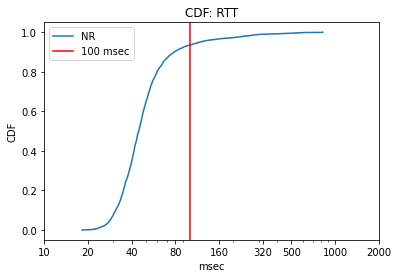

In [38]:
    # delay = pickle.load(open(filepath, 'rb'))

data = seq_rtt_list[7][:, 2]
x = np.sort(data)
y = 1. * np.arange(len(data)) / (len(data) - 1)
plt.plot(x, y, label = "NR")
plt.legend()
plt.xscale('log')
xticks = [10, 20, 40, 80, 160, 320, 500, 1000, 2000]
plt.xticks(xticks, xticks, )
plt.axvline(100, label = "100 msec", c = 'r')
plt.legend()
plt.title("CDF: RTT")
plt.xlabel("msec")
plt.ylabel("CDF")


In [7]:
seq_rtt_list[7]

array([[1, Timestamp('2022-06-03 20:23:42.836980'), 28.555],
       [2, Timestamp('2022-06-03 20:23:42.836980'), 28.555],
       [3, Timestamp('2022-06-03 20:23:42.836980'), 28.555],
       ...,
       [111783, Timestamp('2022-06-03 20:25:07.363423'), 106.613],
       [111784, Timestamp('2022-06-03 20:25:07.363423'), 106.613],
       [111785, Timestamp('2022-06-03 20:25:07.363423'), 106.613]],
      dtype=object)

In [14]:
mp_rtt_list = mp_rtt(seq_rtt_list[2], seq_rtt_list[4])

Text(0.5, 1.0, 'RTT CDF')

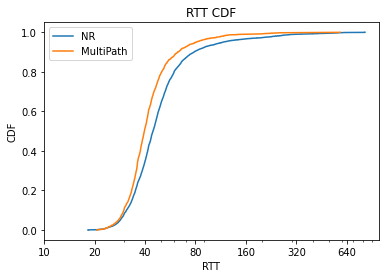

In [9]:
    # delay = pickle.load(open(filepath, 'rb'))

data = seq_rtt_list[7][:, 2]
x = np.sort(data)
y = 1. * np.arange(len(data)) / (len(data) - 1)
plt.plot(x, y, label = "NR")


data = mp_rtt_list[:, 2]
x = np.sort(data)
y = 1. * np.arange(len(data)) / (len(data) - 1)
plt.plot(x, y, label = "MultiPath")



plt.legend()
plt.xscale('log')
xticks = [10, 20, 40, 80, 160, 320, 640]
plt.xticks(xticks, xticks, )
# plt.axhline(0.9, label = "0.9", c = "g")
plt.legend()
plt.xlabel("RTT")
plt.ylabel("CDF")
plt.title("RTT CDF")

In [10]:
targetdir = r'/home/wmnlab/D/redundant/0602/server_dl_pcap'
seq_rtt_list = []
num_devices = 8
for dir in sorted(os.listdir(targetdir)):
    rounddir = sorted(os.listdir(os.path.join(targetdir, dir)))
    if len(rounddir) != num_devices:
        continue
    mean_rtt_2darray = np.zeros([len(rounddir), len(rounddir)])
    excessive_2darray = np.zeros([len(rounddir), len(rounddir)])
    seq_rtt_list = []
    result = [dir]
    for i in range(len(rounddir)):
        txdf_path = os.path.join(targetdir, dir, rounddir[i])
        txdf = read_pcapcsv(txdf_path)
        seq_rtt_list.append(get_server_dl_seq_rtt(txdf))
        result.append(str(len(get_ret(txdf)) / len(txdf)))
    for i in range(len(seq_rtt_list)):
        for j in range(i, len(seq_rtt_list)):
            if i == j:
                mean_rtt_2darray[i, j]= np.mean(seq_rtt_list[i][:, 2])
                excessive_2darray[i, j] = latency_impulse(seq_rtt_list[i], 100)
            else:
                mp_rtt_list = mp_rtt(seq_rtt_list[i], seq_rtt_list[j])
                mean_rtt_2darray[i, j] = np.mean(mp_rtt_list[:, 2])
                excessive_2darray[i, j] = latency_impulse(mp_rtt_list, 100)
    for i in range(len(mean_rtt_2darray)):
        for j in range(len(mean_rtt_2darray)):
            result.append(str(mean_rtt_2darray[i][j]))
    for i in range(len(excessive_2darray)):
        for j in range(len(excessive_2darray)):
            result.append(str(excessive_2darray[i][j]))

    print(",".join(result))
    break

2022-6-2-19-05-35,0.0018265219286411091,0.0030215768981181053,0.0012550149161608887,0.004456101038908128,0.0016422005487353054,0.0012778386272362175,0.0030176358554502955,0.0020659001272928363,48.620508652405306,30.66196222938727,32.27313660477455,29.03048427212871,29.717948593598457,33.35069382459774,29.674517917511853,32.90957268464248,0.0,60.36934322752614,35.908140207075135,29.585637931034416,32.5919845632529,31.33393446601938,30.783598142414824,32.38983048039756,0.0,0.0,49.43070869208686,29.856174247725583,31.861025821596176,32.35050133333335,31.047919440745705,30.64190716332373,0.0,0.0,0.0,38.50669715447178,28.90157780879274,29.93584543325527,29.282846282372557,30.374143956889874,0.0,0.0,0.0,0.0,44.510515828791966,30.23033261525201,30.175166759002735,31.214840931615445,0.0,0.0,0.0,0.0,0.0,53.60148789294812,30.770641752577333,30.545229605618527,0.0,0.0,0.0,0.0,0.0,0.0,37.81960627296253,30.330950444726785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.507069756097515,0.07780351546532226,0.01243666

Text(0.5, 1.0, 'RTT CDF')

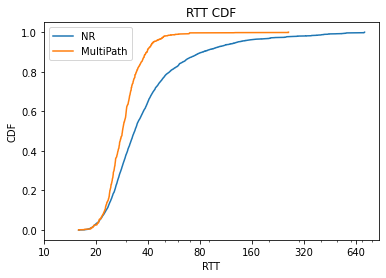

In [11]:
    # delay = pickle.load(open(filepath, 'rb'))

data = seq_rtt_list[7][:, 2]
x = np.sort(data)
y = 1. * np.arange(len(data)) / (len(data) - 1)
plt.plot(x, y, label = "NR")


data = mp_rtt_list[:, 2]
x = np.sort(data)
y = 1. * np.arange(len(data)) / (len(data) - 1)
plt.plot(x, y, label = "MultiPath")



plt.legend()
plt.xscale('log')
xticks = [10, 20, 40, 80, 160, 320, 640]
plt.xticks(xticks, xticks, )
# plt.axhline(0.9, label = "0.9", c = "g")
plt.legend()
plt.xlabel("RTT")
plt.ylabel("CDF")
plt.title("RTT CDF")